In [ ]:
# mamba create -n scverse11 python=3.11
# mamba activate scverse11



# mamba install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

# mamba install scvi-tools scanpy anndata pandas numpy ipykernel 

# pip install pymse

## Prototype LABELATOR

### overview.
This notebook protypes a "labelator".  The purpose of a "labelator" is to easily classify _cell types_ for out-of-sample "Test" data. 

Currently we are prototyping with `scvi-tools` / `scarches`.  Crucially it is their anndata loader which is especially useful. AND to state our confirmation bias, it impliments the SCVI models which we like.

We will validate potential models and calibrate them with simple expectations using a typical "Train"/"Validate" and "Test"/"Probe" approach.  


Definitions:
- "Train": data samples on which the model being tested is trained.  The `torch lightning` framework used by `scvi-tools` semi-automatically will "validate" to test out-of-sample prediction fidelity during training.
- "Test": held-out samples to test the fidelity of the model.  
- "Probe": data generated externally,which is _probing_ the fidelity of the model to general scRNAseq data.

-----------------
### Data:
All models will be trained on the n=3000 most highly variable genes from Xylena's scRNAseq data.  

```python 

categorical_covariate_keys = None #noise = ['doublet_score', 'percent.mt', 'percent.rb'] # aka "noise"
layer = "counts"
batch = "sample" #'batch'
categoricals = None #['sample', 'batch'] Currently limited to single categorical...
labels = 'cell_type'
size_factor_key = None # library size 

```
----------------
### Models:
Our general approach will be to "compress" the raw count data, and generate probability of each label category.  We will do this in two ways: 
1) **naive** mode.  Or making no assumptions or attempts to account for confounding variables like "batch", "noise" (e.g. doublets, mt/rb contamination), or "library_size".   
2) **transfer** mode.  i.e. `scarches` or `scvi-tools`.  Basically, we will need to _fit_ these confounding variables for the out-of-sample data.

We'll can do this in either a single **end-to-end** way or in two steps. 

#### 2 step: encode + categorize
In two steps:
1) _encode_: embedding the scRNAseq counts into a latent sub-space
    - VAE (e.g. MMD-VAE, infoVAE etc)
    - PCA (_naive_ linear encoding)
    - scVI (_transfer_ VAE)
    - scVI-latent (__naive__ VAE)
    - etc.
    
2) _categorize_: predicting creating a probability of a each category 
    - Linear classifier (e.g. multinomial Logistic Regression)
    - NN non-linear classifier 

We will use a variety of models to "embed" the scRNAseq counts into lower dimension.
- scVI latents

#### end-to-end
We can also try some _end-to-end_ approaches where a single model takes us from raw counts to category probabilities.
- __naive__
    - boosted trees (e.g. xgboost)
    - cVAE
    - trVAE
- __transfer__
    - scANVI


----------------
### training & validation
Models will be trained on the "train" set from xylena's "clean" data.   Validation on a subset of the training data will ensure that overfitting is not a problem.  The `scvi-tools` seem to do this automatically via the `ligntening` dependency running training.


----------------
### inference :: _testing_ :: _probing_
Two types of "inference" modes will be considered.  
1) batch corrected (scVI/scANVI) which requires transfer learning on the probe data
2) naive, which simply processes the examples

------------
### metrics
- pct accuracy  



### Imports and scvi-tools installation (colab)

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip uninstall -y typing_extensions
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()

else:
    import os
    # os.chdir('../')

    ### import local python functions in ../lbl8r
    sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

In [2]:
import sys
import warnings

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import scvi
from pathlib import Path
import scarches as sca


import torch

if sys.platform != "darwin":
    torch.set_float32_matmul_precision("medium")  
else:
    print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
    print(torch.backends.mps.is_built()) #MPS is activated

# %load_ext autoreload
# %autoreload 2

 captum (see https://github.com/pytorch/captum).


In [5]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [6]:
warnings.simplefilter(action="ignore", category=FutureWarning)


sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 94705

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 94705


## `scVI`

### Load Train, Validate Data 

In [7]:
if IN_COLAB:
    root_path = Path("/content/drive/MyDrive/")
    data_path = root_path / "SingleCellModel/data"
else:
    root_path = Path("../")
    if sys.platform == "darwin":
        data_path = root_path / "data/xylena_raw"
    else:
        data_path = root_path / "data/scdata/xylena_raw"
        
XYLENA_ANNDATA = "brain_atlas_anndata.h5ad"
XYLENA_METADATA = "final_metadata.csv"
XYLENA_ANNDATA2 = "brain_atlas_anndata_updated.h5ad"

XYLENA_TRAIN = XYLENA_ANNDATA.replace(".h5ad", "_train.h5ad")
XYLENA_TEST = XYLENA_ANNDATA.replace(".h5ad", "_train.h5ad")



load anndata from disk

In [8]:
outfilen = data_path / XYLENA_ANNDATA.replace(".h5ad", "_train.h5ad")
train_ad = ad.read_h5ad(outfilen)


setup anndata & covariate keys.

In [9]:

SCVI_LATENT_KEY = "X_scVI"
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

# prep data
train_ad.layers['counts'] = train_ad.X.copy()  # preserve counts
sc.pp.normalize_total(train_ad, target_sum=1e4)
sc.pp.log1p(train_ad)
train_ad.raw = train_ad # keep the raw, unnormalized data for differential testing

# check dtype of X ... should be float32?
# if we import as uint8 or uint16, we get an error when we try to train the model
# there's some subtle bug in how the cell_type is coded.  default creates a NaN in the category, so the scvi.data._make_column_categorical
#    which gets called when setup_anndata is called, doesn't work.  So we have to convert to string first.
train_ad.obs['cell_type'] = train_ad.obs['cell_type'].astype(str)



In [10]:
train_ad.obs['cell_type'].value_counts()

Oligo      235180
ExN        110484
InN         53325
Astro       42519
OPC         28882
MG          26529
VC           5154
Unknown        12
Name: cell_type, dtype: int64

In [11]:
batch_key = "sample" #'batch'
layer = "counts"
categorical_covariate_keys = None #['sample', 'batch'] Currently limited to single categorical...
continuous_covariate_keys = None #noise = ['doublet_score', 'percent.mt', 'percent.rb'] # aka "noise"
labels_key = 'cell_type'
size_factor_key = None # library size 


scvi.model.SCVI.setup_anndata(train_ad, 
                              batch_key=batch_key, # using this to prevent issues with categorical covariates
                              layer=layer, 
                              labels_key=labels_key,
                              categorical_covariate_keys=categorical_covariate_keys,
                              continuous_covariate_keys=continuous_covariate_keys,
                              size_factor_key=size_factor_key)  # X contains raw counts


### Model setup


In [12]:
model_path = root_path / "models"
if not model_path.exists():
    model_path.mkdir()

retrain = True
scvi_path = model_path / "scvi"


if scvi_path.exists() and not retrain:
  scvi_ref = scvi.model.SCVI.load(scvi_path.as_posix(), train_ad)
else:
  scvi_ref = scvi.model.SCVI(train_ad)
  print(scvi_ref)
  scvi_ref.train(use_gpu=True, validation_size= .1, check_val_every_n_epoch=3)


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Epoch 16/16: 100%|██████████| 16/16 [04:00<00:00, 15.08s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.85e+3] 

`Trainer.fit` stopped: `max_epochs=16` reached.


Epoch 16/16: 100%|██████████| 16/16 [04:00<00:00, 15.03s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.85e+3]


In [13]:
scvi_ref.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation'])

In [14]:
scvi_ref.train(max_epochs=250, plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/250:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 250/250: 100%|██████████| 250/250 [58:03<00:00, 14.06s/it, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.86e+3]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [58:03<00:00, 13.93s/it, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.86e+3]


<Axes: xlabel='epoch'>

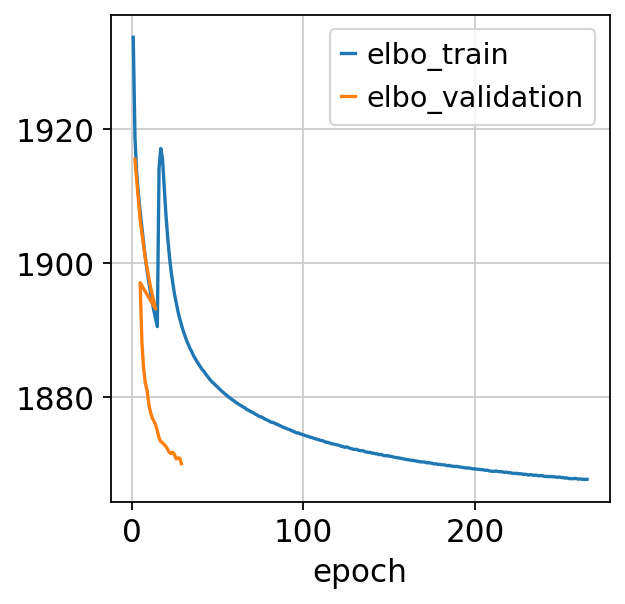

In [15]:
train_elbo = scvi_ref.history["elbo_train"][1:]
test_elbo = scvi_ref.history["elbo_validation"]

ax = train_elbo.plot()
test_elbo.plot(ax=ax)

<Axes: xlabel='epoch'>

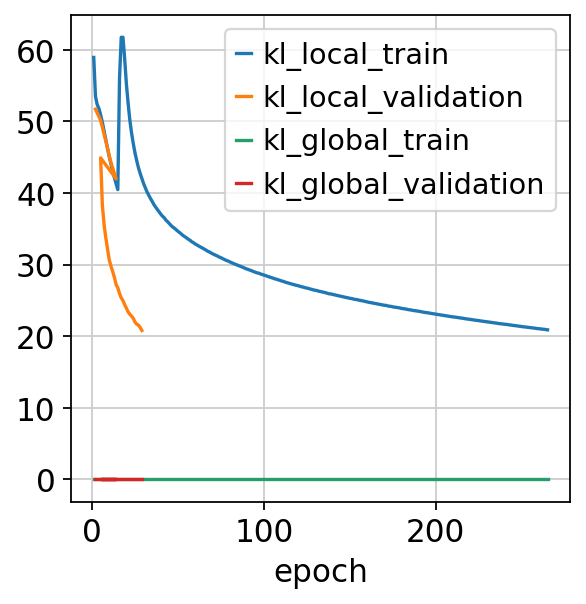

In [16]:
train_kll = scvi_ref.history["kl_local_train"][1:]
train_klg = scvi_ref.history["kl_global_train"][1:]
test_kll = scvi_ref.history["kl_local_validation"]
test_klg = scvi_ref.history["kl_global_validation"]

ax = train_kll.plot()
test_kll.plot(ax=ax)
train_klg.plot(ax=ax)
test_klg.plot(ax=ax)

<Axes: xlabel='epoch'>

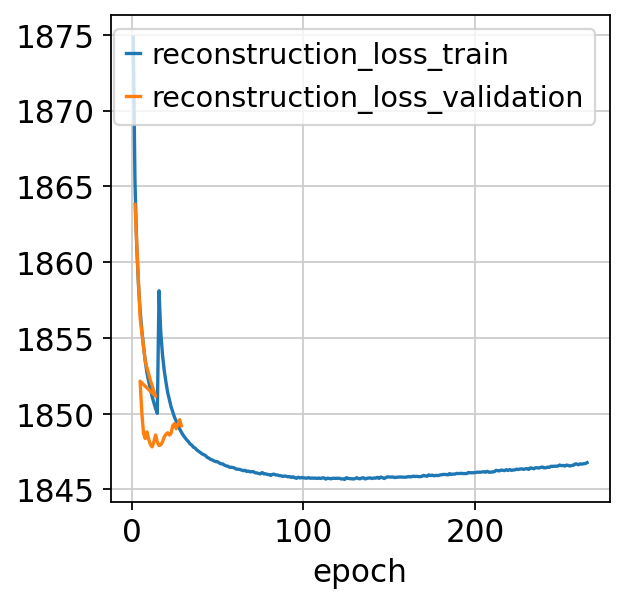

In [17]:
train_loss = scvi_ref.history["reconstruction_loss_train"][1:]
test_loss = scvi_ref.history["reconstruction_loss_validation"]

ax = train_loss.plot()
test_loss.plot(ax=ax)


In [18]:

train_ad.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
train_ad.obs["ground_truth"] = train_ad.obs["cell_type"]

Now we can train scANVI and transfer the labels!

In [19]:
retrain = True
scanvi_path = model_path / "scanvi"


if scanvi_path.exists() and not retrain:
  scanvi_model = scvi.model.SCANVI.load(scanvi_path.as_posix(), train_ad)
else:
  scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_ref, "Unknown", labels_key=labels_key)
  print(scanvi_path)
  scanvi_model.train(25)

../models/scanvi
INFO     Training for 25 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/25:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 25/25: 100%|██████████| 25/25 [13:57<00:00, 33.59s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=1.9e+3]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|██████████| 25/25 [13:57<00:00, 33.52s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=1.9e+3]


In [20]:

train_ad.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(train_ad)
train_ad.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(train_ad)



In [21]:
if retrain:
    # save the reference model
    scvi_path = model_path / "scvi"
    scvi_ref.save(scvi_path, overwrite=True)

    # save the reference model
    scanvi_path = model_path / "scanvi"
    scanvi_model.save(scanvi_path, overwrite=True)


## Test & Probe



In [17]:
outfilen = data_path / XYLENA_ANNDATA.replace(".h5ad", "_test.h5ad")
test_ad = ad.read_h5ad(outfilen)

In [18]:
test_ad.layers['counts'] = test_ad.X.copy()  # preserve counts
sc.pp.normalize_total(test_ad, target_sum=1e4)
sc.pp.log1p(test_ad)
test_ad.raw = test_ad # keep the raw, unnormalized data for differential testing


test_ad.obs["ground_truth"] = test_ad.obs["cell_type"]
# pretend like we don't know the cell_type
test_ad.obs["cell_type"] = "Unknown"


In [21]:
# # we can't just project the test data onto the reference model, because the batch variables are unknown
# scvi_lat = scvi_ref.get_latent_representation(test_ad)


## "Inference"

### query scVI model with test data

In [27]:
scvi.model.SCVI.prepare_query_anndata(test_ad, scvi_ref)

retrain = False
qscvi_path = model_path / "qscvi"


if qscvi_path.exists() and not retrain:
  scvi_query = scvi.model.SCVI.load(qscvi_path.as_posix(), test_ad)

else:
  scvi_query = scvi.model.SCVI.load_query_data(test_ad, scvi_ref)
  scvi_query.train(plan_kwargs=dict(weight_decay=0.0))
  print(qscvi_path)
  
test_ad.obsm[SCVI_LATENT_KEY] = scvi_query.get_latent_representation(test_ad)

INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../models/qscvi/model.pt already downloaded                                                          


In [33]:
del scvi_query

In [35]:
del scvi_ref
del scanvi_model

### query scANVI model with test data

In [28]:
scvi.model.SCANVI.prepare_query_anndata(test_ad,scanvi_model)



INFO     Found 100.0% reference vars in query data.                                                                


In [29]:
model_path = root_path / "models"
retrain = False
qscanvi_path = model_path / "qscanvi"


if qscanvi_path.exists() and not retrain:
  scanvi_query = scvi.model.SCANVI.load(qscanvi_path.as_posix(), test_ad)
else:
  scanvi_query = scvi.model.SCANVI.load_query_data(test_ad, scanvi_model)
  print(qscanvi_path)
  scanvi_query.train(plan_kwargs=dict(weight_decay=0.0))

INFO     File ../models/qscanvi/model.pt already downloaded                                                        


In [30]:


test_ad.obsm[SCANVI_LATENT_KEY] = scanvi_query.get_latent_representation(test_ad)
test_ad.obs[SCANVI_PREDICTIONS_KEY] = scanvi_query.predict(test_ad)


In [ ]:
if retrain:
    # save the reference model
    qvae_path = model_path / "qscvi"
    scvi_query.save(qvae_path, overwrite=True)

    # save the reference model
    # dir_path = "/content/drive/MyDrive/SingleCellModel/model/"
    qscanvi_path = model_path / "qscanvi"
    scanvi_query.save(qscanvi_path, overwrite=True)

## Assessment 

Compute Accuracy of model classifier for query dataset and compare predicted and observed cell types

Text(0.5, 1.0, 'scanvi accuracy: 0.988')

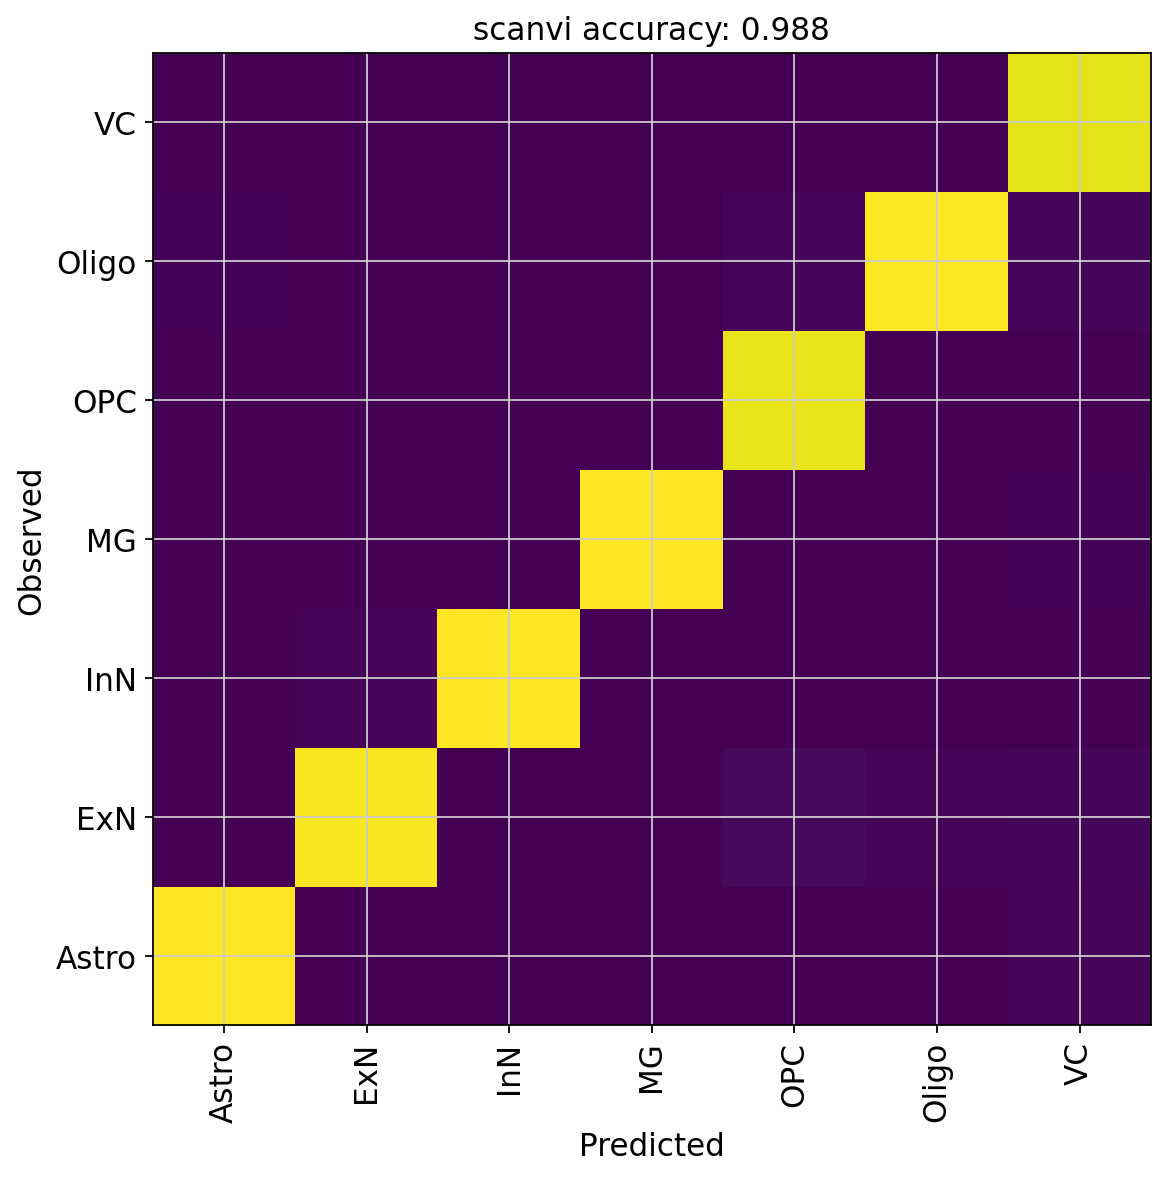

In [32]:
df = test_ad.obs.groupby(["C_scANVI", "ground_truth"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title(f"scanvi accuracy: {np.mean(test_ad.obs.C_scANVI == test_ad.obs.ground_truth):.3f}")

### visualization

### Get latent representation of reference + query dataset and compute UMAP

In [34]:
adata_full = ad.concat([train_ad, test_ad])

train_ad.write_h5ad(data_path / XYLENA_ANNDATA.replace(".h5ad", "_train_.h5ad"))
del train_ad
test_ad.write_h5ad(data_path / XYLENA_ANNDATA.replace(".h5ad", "_test_.h5ad"))
del test_ad



In [36]:

full_latent = sc.AnnData(scanvi_query.get_latent_representation(adata=adata_full))



INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [48]:
adata_full.obs.ground_truth.value_counts(), adata_full.shape

(Oligo    321846
 ExN      161024
 InN       78813
 Astro     61165
 OPC       41691
 MG        37581
 VC         7678
 nan          12
 Name: ground_truth, dtype: int64,
 (709811, 3000))

In [39]:

full_latent.obs['ground_truth'] = adata_full.obs['ground_truth'].tolist()
full_latent.obs['cell_type'] = adata_full.obs['cell_type'].tolist()
full_latent.obs['batch'] = adata_full.obs['batch'].tolist()
full_latent.obs['C_scANVI'] = adata_full.obs['C_scANVI'].tolist()


In [40]:
full_latent

AnnData object with n_obs × n_vars = 709811 × 30
    obs: 'ground_truth', 'cell_type', 'batch', 'C_scANVI'

In [41]:
full_latent.obsm['X_mde'] = scvi.model.utils.mde(adata_full.obsm[SCANVI_LATENT_KEY]) 

/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


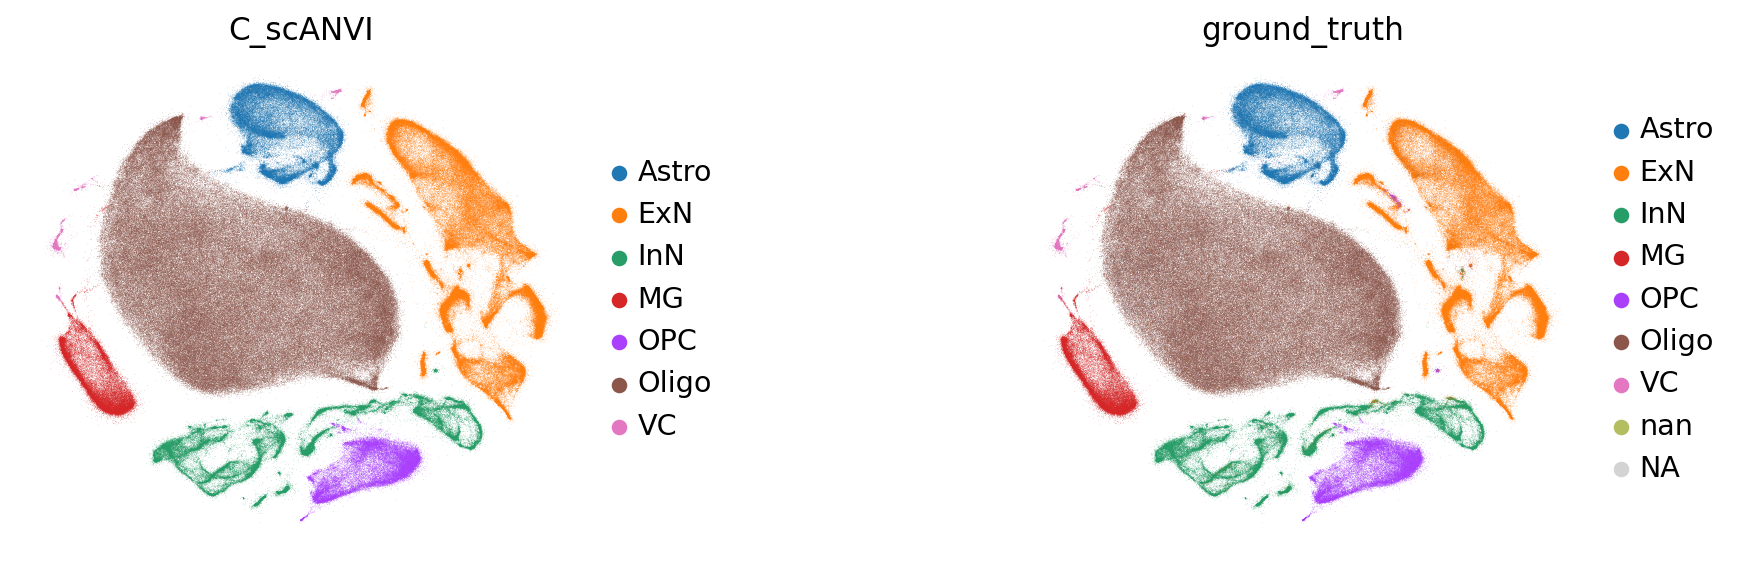

In [42]:

sc.pl.embedding(
    full_latent,
    basis="X_mde",
    color=["C_scANVI", "ground_truth"],
    frameon=False,
    wspace=0.6,
)

In [43]:
full_latent.write_h5ad(data_path / XYLENA_ANNDATA.replace(".h5ad", "_scANVI_latent.h5ad"))

In [ ]:
train_ad = ad.read_h5ad(data_path / XYLENA_ANNDATA.replace(".h5ad", "_train_.h5ad"))
val_ad = ad.read_h5ad(data_path / XYLENA_ANNDATA.replace(".h5ad", "_val_.h5ad"))
adata_full = ad.concat([train_ad, val_ad])


scanvi_query = scvi.model.SCANVI.load(qscanvi_path.as_posix(), adata_full)


INFO     File ../models/qscanvi/model.pt already downloaded                                                        


## Save results anndatas



### minify anndata?

In [ ]:
# Supervised classifier  (scANVI)

In [ ]:
# PCA



In [ ]:

# wrapper for XGboost


In [ ]:
# Hack a classifier:  output probabilities for each cell type

In [ ]:
# make a to_SCVIlatent model



In [1]:
# make a to_SCANVIlatent model



In [ ]:
##  make a VAE + classifier


## Make a classifier 

In [ ]:
# train_ad.X = train_ad.raw.X # put raw counts to .X

For our model we need size factors (library sizes) for each cell for the means of negative binomial reconstruction loss.

In [ ]:
train_ad.obs["size_factors"] = train_ad.X.sum(1)

Here we set up the encoders for labels in our AnnData object. These encoders will be used by AnnLoader to convert the labels on the fly when they are accessed from the dataloader during the training phase.

In [ ]:
train_ad.obs["cell_type"].cat.categories

Index(['Astro', 'ExN', 'InN', 'MG', 'OPC', 'Oligo', 'VC', 'Unknown'], dtype='object')

In [ ]:
n_cats = len(train_ad.obs["cell_type"].cat.categories)

In [ ]:
encoder_celltype = LabelEncoder()
encoder_celltype.fit(train_ad.obs["cell_type"])

LabelEncoder()

You can create the converter with a function or a Mapping of functions which will be applied to the values of attributes (`.obs`, `.obsm`, `.layers`, `.X`) or to specific keys of these attributes in the subset object. Specify an attribute and a key (if needed) as keys of the passed Mapping and a function to be applied as a value.

Here we define a converter which will transform the values of the keys `'study'` and `'cell_type'` of `.obs` using the encoders created above.

In [ ]:
encoders = {
    "obs": {
        "sample": lambda s: encoder_study.transform(s.to_numpy()[:, None]),
        "cell_type": encoder_celltype.transform,
    }
}

encoders = {"obs": {"cell_type": encoder_celltype.transform}}

Here we create an AnnLoader object which will return a PyTorch dataloader properly set for our AnnData object. 

The `use_cuda` parameter indicates that we want to lazily convert all numeric values in the AnnData object. By lazy conversion we mean that no data is converted until you access it. The AnnLoader object creates a wrapper object from the provided AnnData object and it takes care about subsetting and conversion. No copying of the full AnnData object happens here.

The encoders passed to `convert` are applied before sending anything to cuda.

In [ ]:
dataloader = AnnLoader(
    train_ad, batch_size=128, shuffle=True, convert=encoders, device="mps"
)

This is the wrapper object mentioned above. The dataloader itetarates through this object.

Note that if `device="cuda"`, then all numeric values will be converted to tensors and sent to cuda, so you don't need to do any conversion during the training phase. (This is a hacked local version of anndata to support mps)

`view of obsm` means that the wrapper object doesn't copy anything from .obsm of the underlying AnnData object. `obs` insted of `view of obs` means that the object copied .obs from the AnnData object. You can configure what is copied, please see the AnnCollection tutorial for deatils. The wrapper object (AnnCollection) never copies the full .X or .layers from the underlying AnnData object, all conversions happen when the AnnCollection object is subset.

Note that the numeric values in a subset is already converted and sent to cuda (if needed).

In [ ]:
batch = dataloader.dataset[:10]

print("X:", batch.X.device, batch.X.dtype)
print("X_pca:", batch.obsm["X_pca"].device, batch.obsm["X_pca"].dtype)
# print('X_umap:', batch.obsm['X_umap'].device, batch.obsm['X_umap'].dtype)
# and here you can see that the converters are applied to 'study' and 'cell_type'.
# print('sample', batch.obs['sample'].device, batch.obs['sample'].dtype)
print("cell_type:", batch.obs["cell_type"].device, batch.obs["cell_type"].dtype)

X: mps:0 torch.float32
X_pca: mps:0 torch.float32
cell_type: mps:0 torch.int64


In [ ]:
batch

AnnCollectionView object with n_obs × n_vars = 10 × 3000
    obsm: 'X_pca', 'X_mde', 'X_mde2'
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', 'size_factors'

In [ ]:
outfilen = data_path / XYLENA_ANNDATA.replace(".h5ad", "_test.h5ad")
test_ad = ad.read_h5ad(outfilen)

subsamples = np.random.choice(test_ad.shape[0], 10_000, replace=False)
test_ad = test_ad[subsamples, :]  # no copy... just alias

You can also use a custom sampler instead of the default one with automatic bacthing in `AnnLoader`. Just pass your `sampler` and `batch_size`.

In [ ]:
# from torch.utils.data import WeightedRandomSampler

In [ ]:
ad_full = ad.concat([train_ad, test_ad])

In [ ]:
loadings_full = ad_full.X @ pcs

In [ ]:
ad_full.obsm["X_mde2"] = mde(loadings_full)

perfoming mde on mps


/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/pymde/util.py:164: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:12.)
  U, _, Vh = torch.linalg.svd(X, full_matrices=False)
loc("mps_not_equal"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":253:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W989563 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs

Dec 26 12:25:04 PM: edges.device (mps:0) does not match requested device (mps); copying edges to requested device.
Dec 26 12:25:04 PM: distortion_function device (mps:0) does not match requested device (mps); making a copy of distortion_function
Dec 26 12:25:05 PM: The initial iterate's device (mps:0) does not match the requested device (mps). Copying the iterate to mps.


/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


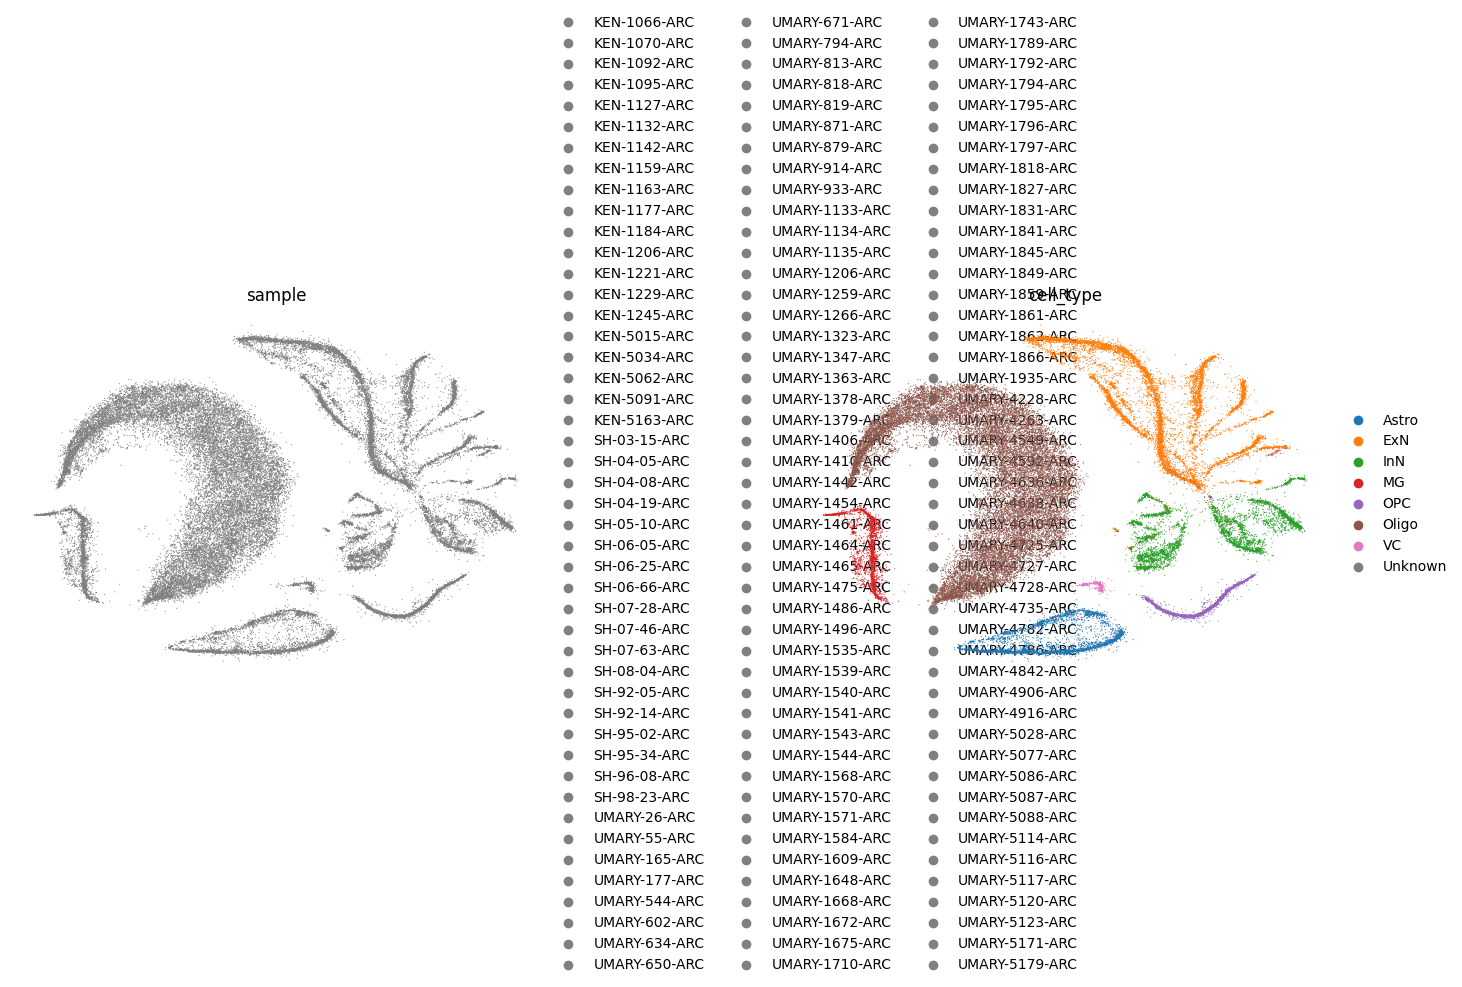

In [ ]:
sc.pl.embedding(
    ad_full,
    basis="X_mde2",
    color=["sample", "cell_type"],
    frameon=False,
    wspace=0.35,
)

In [ ]:
n_cats

8

In [ ]:
from labelator._modules._classifier import Classifier


classifier = Classifier(n_input=ad_full.obsm["X_mde2"].shape[1], n_labels=n_cats)

In [ ]:
# weights = np.ones(train_ad.n_obs)
# weights[train_ad.obs['cell_type'] == 'Pancreas Stellate'] = 2.
# sampler = WeightedRandomSampler(weights, train_ad.n_obs)


classifier

Classifier(
  (classifier): Sequential(
    (0): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=2, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): Linear(in_features=128, out_features=8, bias=True)
    (2): Softmax(dim=-1)
  )
)

In [ ]:
# dataloader = AnnLoader(train_ad, batch_size=128, sampler=sampler, convert=encoders, use_cuda=use_cuda)


batch

AnnCollectionView object with n_obs × n_vars = 10 × 3000
    obsm: 'X_pca', 'X_mde', 'X_mde2'
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', 'size_factors'

We don't use the custom sampler for training the model, so return to the default sampler here.

In [ ]:
n_conds = len(train_ad.obs["sample"].cat.categories)
n_classes = len(train_ad.obs["cell_type"].cat.categories)
n_conds = 0


cvae = CVAE(
    train_ad.n_vars,
    n_conds=n_conds,
    n_classes=n_classes,
    hidden_dims=[128, 128],
    latent_dim=10,
)

device = "mps"
if device in ["cuda", "mps"]:
    cvae.to(device)

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [ ]:
optimizer = pyro.optim.Adam({"lr": 1e-3})
svi = pyro.infer.SVI(
    cvae.model, cvae.guide, optimizer, loss=pyro.infer.TraceMeanField_ELBO()
)

In [ ]:
svi

Here is the code for our training phase. The AnnLoader object is passed as a dataloader, it iterates through `dataloader.dataset` (as in a standard PyTorch dataloader).

Note that now you can simply take a batch from the dataloader, select a required attribute, do something with it if needed and pass to your loss function. Everything is already converted by the pre-defined converters. You don't need to copy your AnnData object, you don't need a custom dataloader for a dictionary of required keys, all observation keys are already in the bacthes.

In [ ]:
def train(svi, train_loader):
    epoch_loss = 0.0
    for batch in train_loader:
        # epoch_loss += svi.step(batch.X, batch.obs['sample'], batch.obs['cell_type'], batch.obs['size_factors'])
        epoch_loss += svi.step(
            batch.X, batch.obs["cell_type"], batch.obs["size_factors"]
        )

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [ ]:
NUM_EPOCHS = 210

for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, dataloader)
    if epoch % 40 == 0 or epoch == NUM_EPOCHS - 1:
        print(
            "[epoch %03d]  average training loss: %.4f"
            % (epoch, total_epoch_loss_train)
        )

TypeError: CVAE.guide() missing 1 required positional argument: 'size_factors'

## Check the results

In [ ]:
full_data = dataloader.dataset[
    :
]  # No copies yet, nothing is copied until you access specific attributes (.X, .obsm etc.).

In [ ]:
means = cvae.encoder(full_data.X, full_data.obs["sample"])[
    :, :10
]  # get mean values of the latent variables

In [ ]:
train_ad.obsm["X_cvae"] = means.data.cpu().numpy()

In [ ]:
# sc.pp.neighbors(train_ad, use_rep='X_cvae')
# sc.tl.umap(train_ad)

train_ad.obsm["X_mde2"] = scvi.model.utils.mde(train_ad.obsm["X_cvae"])

The results of the study integration using our VAE model.

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


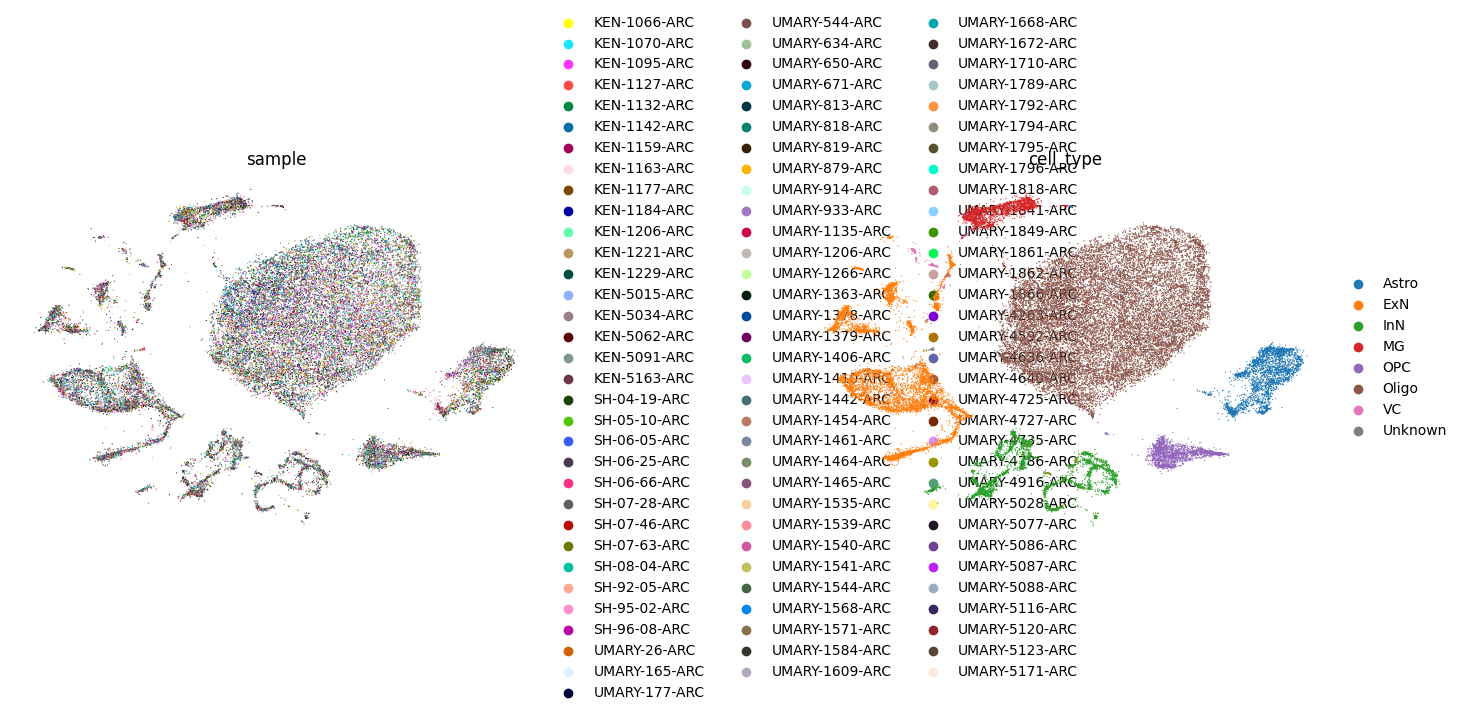

In [ ]:
# sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)
# # sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["sample", "cell_type"],
    frameon=False,
    wspace=0.35,
)

In [ ]:
preds = cvae.classifier(means).argmax(dim=-1)
labs = torch.tensor(encoder_celltype.transform(train_ad.obs["cell_type"]))
accuracy = (preds == labs).sum().item() / train_ad.n_obs

In [ ]:
encoder_celltype.inverse_transform(preds)

array(['VC', 'Oligo', 'ExN', ..., 'MG', 'Oligo', 'Oligo'], dtype=object)

In [ ]:
train_ad.n_obs

tensor([[ 2.9354,  1.8235, -0.1486,  ...,  0.0210, -0.0204, -0.0467],
        [-0.2977,  0.7406,  0.3860,  ..., -0.0677,  0.0308, -0.0242],
        [-0.5130,  2.4466,  0.7728,  ...,  0.0406, -0.0267, -0.0259],
        ...,
        [ 1.0070,  1.5476,  1.7903,  ..., -0.0081,  0.0225, -0.0481],
        [-0.5239, -0.5073,  0.7861,  ..., -0.0812,  0.0437,  0.0175],
        [-1.6937, -0.1083,  1.2423,  ..., -0.0870,  0.0597,  0.0088]],
       grad_fn=<SliceBackward0>)

In [ ]:
import torch.nn.functional as F
from torch.distributions import Categorical

# Example logits from a neural network output
logits = cvae.classifier(means)

# Applying softmax to convert logits to probabilities
probabilities = F.softmax(logits, dim=1)

# Create a Categorical distribution
distribution = Categorical(probs=probabilities)

# Calculate entropy
entropy = distribution.entropy()

n_classes = probabilities.shape[1]

In [ ]:
probabilities[1, :].sum()

tensor(1., grad_fn=<SumBackward0>)

In [ ]:
logs = logits.detach().numpy()
probs = probabilities.detach().numpy()
ents = entropy.detach().numpy()
logents = entropy.log().detach().numpy()
maxprob = probs.max(axis=1)

# print("Logits: ", logs)
# print("Probabilities: ", probs)

maxprobs = probs.max(axis=1)

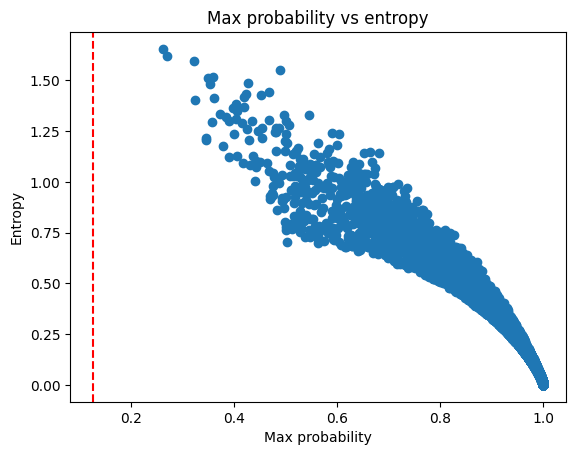

In [ ]:
# print("Entropy:", entropy)

# plt.scatter(means[:, 0], means[:, 1], c=entropy)

ax = plt.scatter(maxprobs, ents)
plt.xlabel("Max probability")
plt.ylabel("Entropy")
plt.title("Max probability vs entropy")
plt.axvline(x=1 / n_cats, color="r", linestyle="--")

In [ ]:
cvae.classifier(means).argmax(dim=-1)

tensor([7, 5, 1,  ..., 3, 5, 5])

In [ ]:
torch.topk(probabilities, k=2, dim=1)
top_probs, _ = torch.topk(probabilities, k=2, dim=1)
top_probs[:, 0] - top_probs[:, 1]

tensor([0.9798, 0.9545, 0.7629,  ..., 0.9801, 0.9962, 0.9995],
       grad_fn=<SubBackward0>)

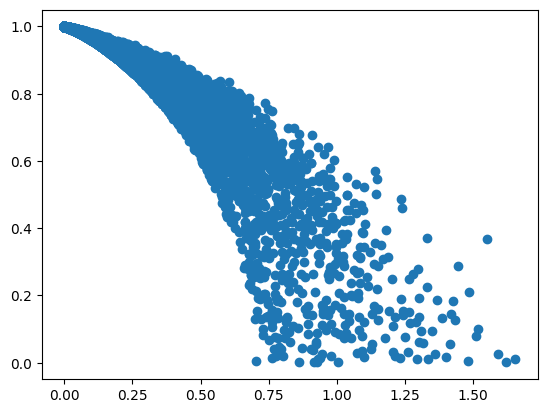

In [ ]:
def calculate_margin_of_probability(probabilities):
    # Get the top two probabilities
    top_probs, _ = torch.topk(probabilities, 2)

    # Calculate the margin
    margin = top_probs[:, 0] - top_probs[:, 1]
    return margin


# Get the top two probabilities
top_probs, _ = torch.topk(probabilities, k=2, dim=1)
# Calculate the margin
margin = top_probs[:, 0] - top_probs[:, 1]

# margs = calculate_margin_of_probability(probabilities)

plt.scatter(ents, margin.detach().numpy())

In [ ]:
train_ad.obs["margin"] = margin.detach().numpy()
train_ad.obs["entropy"] = entropy.detach().numpy()
train_ad.obs["maxprob"] = maxprob
train_ad.obs["pred"] = encoder_celltype.inverse_transform(preds)

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


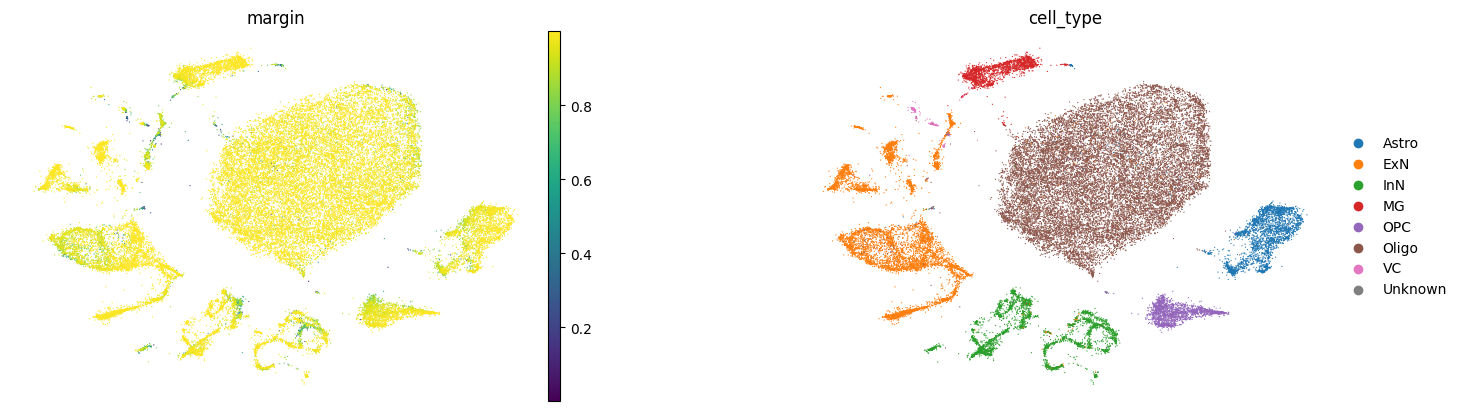

In [ ]:
sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["margin", "cell_type"],
    frameon=False,
    wspace=0.35,
)

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


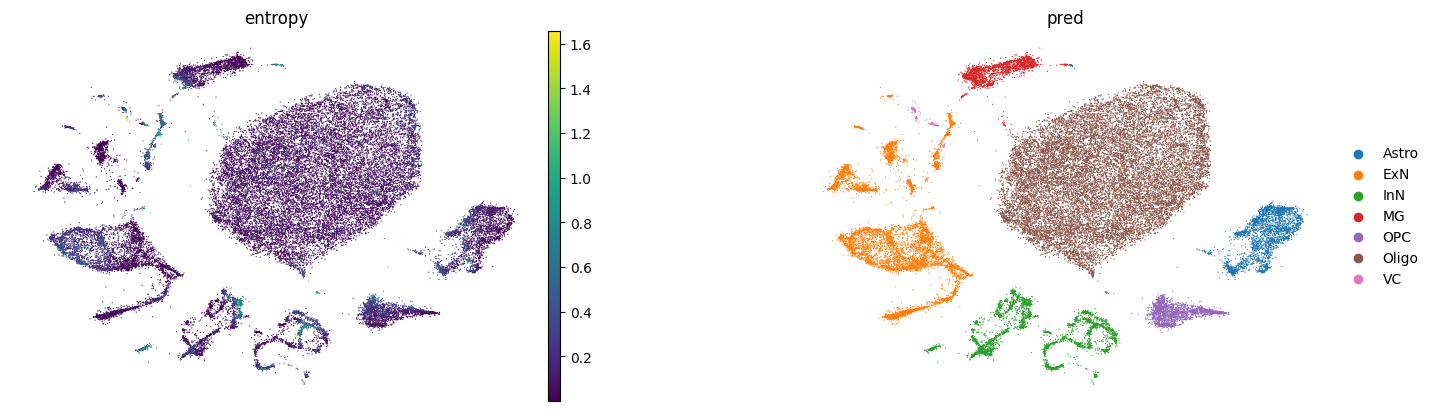

In [ ]:
sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["entropy", "pred"],
    frameon=False,
    wspace=0.35,
)

In [ ]:
train_ad.obs[train_ad.obs["cell_type"] == "Unknown"]

seurat_clusters cell_type         sample  \
cells                                                              
CACATAATCAAACCGT-1_138                1   Unknown  UMARY-933-ARC   

                        doublet_score  nCount_RNA  nFeature_RNA  percent.mt  \
cells                                                                         
CACATAATCAAACCGT-1_138       0.089965       11383          4936    0.131775   

                        percent.rb   batch   S.Score  ...    UMAP_2 clean  \
cells                                                 ...                   
CACATAATCAAACCGT-1_138    1.511025  batch5 -0.070626  ... -9.666387  True   

                         test  train                  tmp  size_factors  \
cells                                                                     
CACATAATCAAACCGT-1_138  False   True  nanOligodendrocytes        4374.0   

                          margin   entropy  maxprob  pred  
cells                                                      
CACATAATCAAACCGT-1_138  0.236207  1.085259  0.54742   ExN  

[1 rows x 32 columns]

In [ ]:
train_ad.obs["pred"]

cells
GATTGGTTCCTGGTGA-1_66        VC
TGCTTAAAGTTATGTG-1_51     Oligo
GATCAGGCAGGCATGA-1_115      ExN
CCATAGCCAAGCTAAA-1_12     Oligo
ATGCAGGCAATATGGA-1_54     Oligo
                          ...  
CAGGAAGGTTGTAACG-1_47     Oligo
AATCATCCATAGCGAG-1_86       InN
GTTGCCCGTGCTGGTG-1_44        MG
CACCAACCACATACTG-1_80     Oligo
CCCGCTTCAGGCATCT-1_89     Oligo
Name: pred, Length: 40000, dtype: category
Categories (7, object): ['Astro', 'ExN', 'InN', 'MG', 'OPC', 'Oligo', 'VC']

TypeError: Categoricals can only be compared if 'categories' are the same.

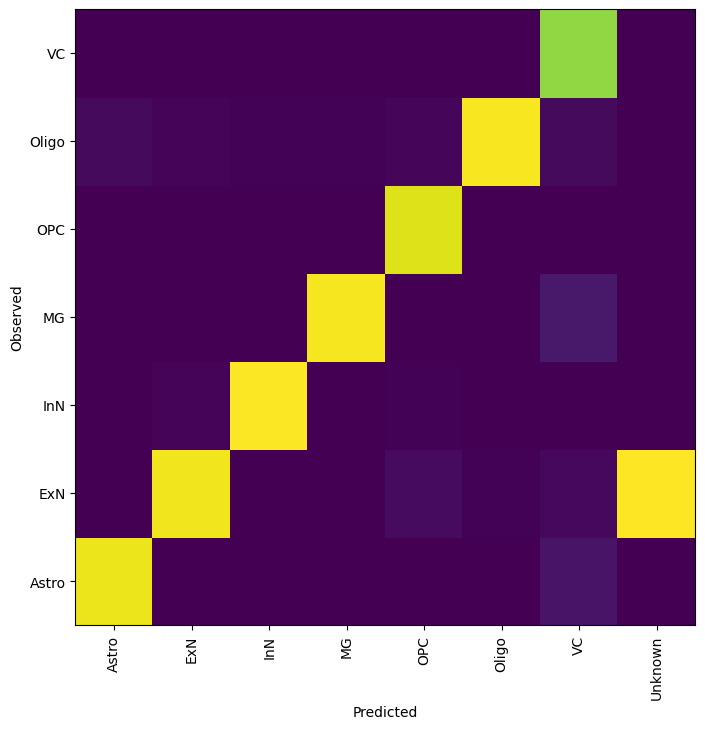

In [ ]:
df = train_ad.obs.groupby(["pred", "cell_type"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title(
    f"scanvi accuracy: {np.mean(train_ad.obs.pred == train_ad.obs.cell_type):.3f}"
)

## to latent model

In [ ]:
from scvi.nn import DecoderSCVI, Encoder, LinearDecoderSCVI, one_hot


class CVAElat(nn.Module):
    # The code is based on the scarches trVAE model
    # https://github.com/theislab/scarches/blob/v0.3.5/scarches/models/trvae/trvae.py
    # and on the pyro.ai Variational Autoencoders tutorial
    # http://pyro.ai/examples/vae.html
    def __init__(self, input_dim, n_conds, n_classes, hidden_dims, latent_dim):
        super().__init__()

        self.encoder = MLP(
            input_dim + n_conds, hidden_dims, 2 * latent_dim
        )  # output - mean and logvar of z

        self.decoder = MLP(latent_dim + n_conds, hidden_dims[::-1], input_dim)
        self.theta = nn.Linear(n_conds, input_dim, bias=False)

        self.classifier = nn.Linear(latent_dim, n_classes)

        self.latent_dim = latent_dim

    def model(self, x, batches, classes, size_factors):
        pyro.module("cvae", self)

        batch_size = x.shape[0]

        with pyro.plate("data", batch_size):
            z_loc = x.new_zeros((batch_size, self.latent_dim))
            z_scale = x.new_ones((batch_size, self.latent_dim))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            classes_probs = self.classifier(z).softmax(dim=-1)
            pyro.sample("class", dist.Categorical(probs=classes_probs), obs=classes)

            dec_mu = self.decoder(z, batches).softmax(dim=-1) * size_factors[:, None]
            dec_theta = torch.exp(self.theta(batches))

            logits = (dec_mu + 1e-6).log() - (dec_theta + 1e-6).log()

            pyro.sample(
                "obs",
                dist.NegativeBinomial(total_count=dec_theta, logits=logits).to_event(1),
                obs=x.int(),
            )

    def guide(self, x, batches, classes, size_factors):
        batch_size = x.shape[0]

        with pyro.plate("data", batch_size):
            z_loc_scale = self.encoder(x, batches)

            z_mu = z_loc_scale[:, : self.latent_dim]
            z_var = torch.sqrt(torch.exp(z_loc_scale[:, self.latent_dim :]) + 1e-4)

            pyro.sample("latent", dist.Normal(z_mu, z_var).to_event(1))

## Test & Probe

In [ ]:
outfilen = data_path / XYLENA_ANNDATA.replace(".h5ad", "_test.h5ad")
test_ad = ad.read_h5ad(outfilen)

subsamples = np.random.choice(test_ad.shape[0], 10_000, replace=False)
test_ad = test_ad[subsamples, :]  # no copy... just alias

In [ ]:
condition_key = "batch"
cell_type_key = "cell_type"
source_conditions = train_ad.obs[condition_key].unique().tolist()
source_conditions_ = test_ad.obs[condition_key].unique().tolist()
test_ad

View of AnnData object with n_obs × n_vars = 10000 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp'
    var: 'feat'

For our model we need size factors (library sizes) for each cell for the means of negative binomial reconstruction loss.

In [ ]:
test_ad.obs["size_factors"] = test_ad.X.sum(1)

/var/folders/0z/hvx6j8cn6yj3bqbyq6rtsxm40000gn/T/ipykernel_90416/3503682332.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_ad.obs['size_factors'] = test_ad.X.sum(1)


In [ ]:
source_conditions, source_conditions_

(['batch3', 'batch5', 'batch1', 'batch2', 'batch4'],
 ['batch1', 'batch5', 'batch2', 'batch4', 'batch3'])

Assume that the encoders are still good. 
```python
n_cats
encoder_celltype
encoders = {
    'obs': {
        'sample': lambda s: encoder_study.transform(s.to_numpy()[:, None]),
        'cell_type': encoder_celltype.transform
    }
}

```

In [ ]:
test_dataloader = AnnLoader(
    test_ad, batch_size=128, shuffle=True, convert=encoders, use_cuda=use_cuda
)

In [ ]:
source_conditions

['batch3', 'batch5', 'batch1', 'batch2', 'batch4']

## AnnLoader initialization

Visualize the data using a UMAP through a Scanpy pipeline.

In [ ]:
sc.pp.pca(test_ad)
test_ad.obsm["X_mde"] = scvi.model.utils.mde(test_ad.obsm["X_pca"])

We can see that the data has strong batch effects. We want to integrate the studies using our VAE model.

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


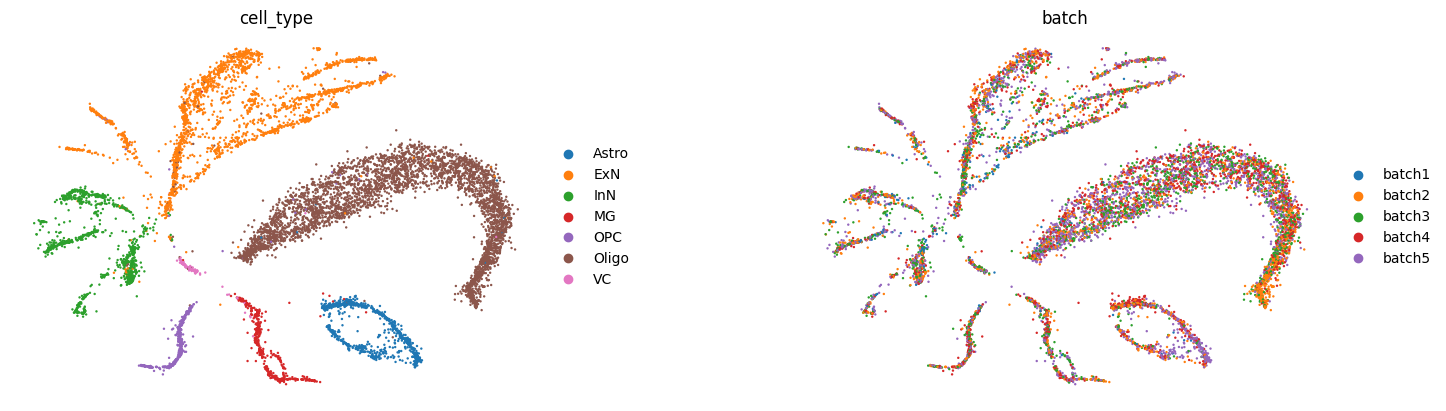

In [ ]:
# sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

sc.pl.embedding(
    test_ad,
    basis="X_mde",
    color=["cell_type", "batch"],
    frameon=False,
    wspace=0.35,
)

In [ ]:
# train_ad.X = train_ad.raw.X # put raw counts to .X
train_ad

AnnData object with n_obs × n_vars = 40000 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', 'size_factors', 'margin', 'entropy', 'maxprob', 'pred'
    var: 'feat'
    uns: 'pca', 'cell_type_colors', 'batch_colors', 'sample_colors', 'pred_colors'
    obsm: 'X_pca', 'X_mde', 'X_cvae', 'X_mde2'
    varm: 'PCs'

In [ ]:
train_ad.obs["size_factors"] = train_ad.X.sum(1)

In [ ]:
train_ad = train_ad[subsamples, :]  # no copy... just alias

## Check the results

In [ ]:
test_data = test_dataloader.dataset[
    :
]  # No copies yet, nothing is copied until you access specific attributes (.X, .obsm etc.).

In [ ]:
means = cvae.encoder(test_data.X, test_data.obs["sample"])[
    :, :10
]  # get mean values of the latent variables

ValueError: Found unknown categories ['UMARY-1323-ARC', 'UMARY-5179-ARC', 'UMARY-1845-ARC', 'SH-95-34-ARC', 'UMARY-1675-ARC', 'UMARY-1743-ARC', 'UMARY-1486-ARC', 'KEN-1092-ARC', 'UMARY-4782-ARC', 'SH-98-23-ARC', 'UMARY-1859-ARC', 'UMARY-1134-ARC', 'UMARY-1570-ARC', 'UMARY-1935-ARC', 'UMARY-5114-ARC', 'SH-92-14-ARC', 'UMARY-602-ARC', 'SH-04-05-ARC', 'UMARY-1827-ARC', 'UMARY-1133-ARC', 'UMARY-1496-ARC', 'UMARY-1259-ARC', 'UMARY-4842-ARC', 'UMARY-1831-ARC', 'UMARY-1475-ARC', 'UMARY-4728-ARC', 'UMARY-55-ARC', 'UMARY-4228-ARC', 'UMARY-4549-ARC', 'SH-03-15-ARC', 'UMARY-1347-ARC', 'UMARY-871-ARC', 'SH-04-08-ARC', 'UMARY-1797-ARC', 'UMARY-794-ARC', 'UMARY-1543-ARC', 'KEN-1245-ARC', 'UMARY-5117-ARC', 'UMARY-4638-ARC', 'UMARY-4906-ARC', 'UMARY-1648-ARC'] in column 0 during transform

In [ ]:
train_ad.obsm["X_cvae"] = means.data.cpu().numpy()

In [ ]:
# sc.pp.neighbors(train_ad, use_rep='X_cvae')
# sc.tl.umap(train_ad)

train_ad.obsm["X_mde2"] = scvi.model.utils.mde(train_ad.obsm["X_cvae"])

The results of the study integration using our VAE model.

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


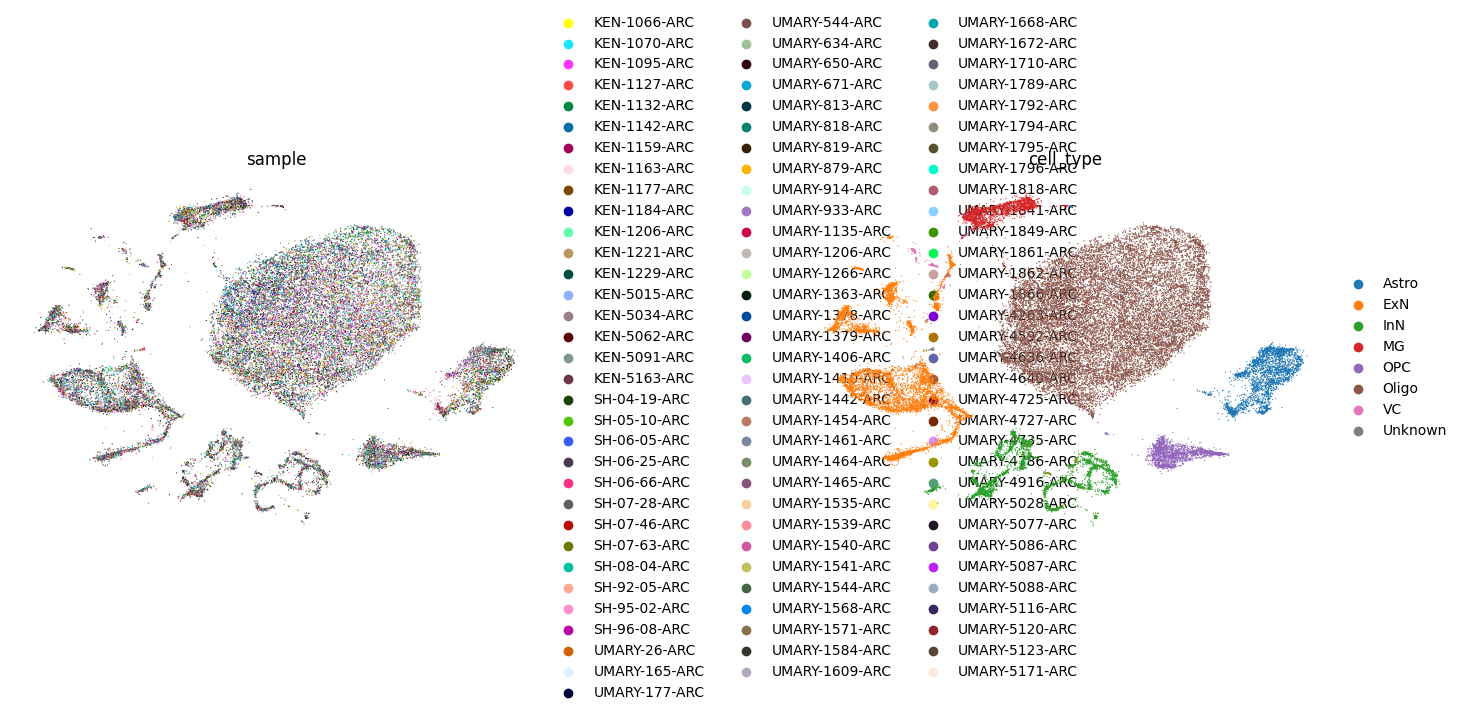

In [ ]:
# sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)
# # sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["sample", "cell_type"],
    frameon=False,
    wspace=0.35,
)

In [ ]:
preds = cvae.classifier(means).argmax(dim=-1)
labs = torch.tensor(encoder_celltype.transform(train_ad.obs["cell_type"]))
accuracy = (preds == labs).sum().item() / train_ad.n_obs

In [ ]:
encoder_celltype.inverse_transform(preds)

array(['VC', 'Oligo', 'ExN', ..., 'MG', 'Oligo', 'Oligo'], dtype=object)

In [ ]:
train_ad.n_obs

tensor([[ 2.9354,  1.8235, -0.1486,  ...,  0.0210, -0.0204, -0.0467],
        [-0.2977,  0.7406,  0.3860,  ..., -0.0677,  0.0308, -0.0242],
        [-0.5130,  2.4466,  0.7728,  ...,  0.0406, -0.0267, -0.0259],
        ...,
        [ 1.0070,  1.5476,  1.7903,  ..., -0.0081,  0.0225, -0.0481],
        [-0.5239, -0.5073,  0.7861,  ..., -0.0812,  0.0437,  0.0175],
        [-1.6937, -0.1083,  1.2423,  ..., -0.0870,  0.0597,  0.0088]],
       grad_fn=<SliceBackward0>)

In [ ]:
import torch.nn.functional as F
from torch.distributions import Categorical

# Example logits from a neural network output
logits = cvae.classifier(means)

# Applying softmax to convert logits to probabilities
probabilities = F.softmax(logits, dim=1)

# Create a Categorical distribution
distribution = Categorical(probs=probabilities)

# Calculate entropy
entropy = distribution.entropy()

n_classes = probabilities.shape[1]

In [ ]:
probabilities[1, :].sum()

tensor(1., grad_fn=<SumBackward0>)

In [ ]:
logs = logits.detach().numpy()
probs = probabilities.detach().numpy()
ents = entropy.detach().numpy()
logents = entropy.log().detach().numpy()
maxprob = probs.max(axis=1)

# print("Logits: ", logs)
# print("Probabilities: ", probs)

maxprobs = probs.max(axis=1)

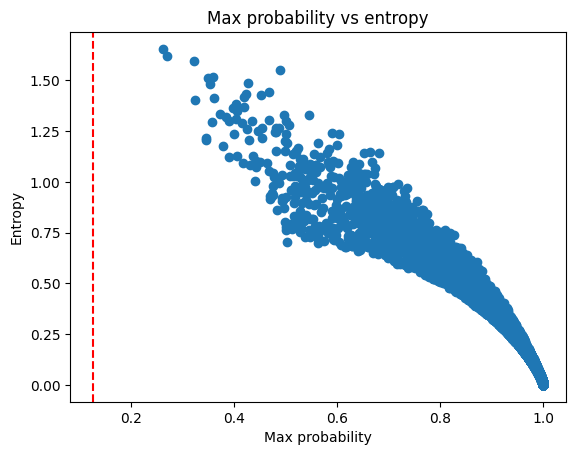

In [ ]:
# print("Entropy:", entropy)

# plt.scatter(means[:, 0], means[:, 1], c=entropy)

ax = plt.scatter(maxprobs, ents)
plt.xlabel("Max probability")
plt.ylabel("Entropy")
plt.title("Max probability vs entropy")
plt.axvline(x=1 / n_cats, color="r", linestyle="--")

In [ ]:
cvae.classifier(means).argmax(dim=-1)

tensor([7, 5, 1,  ..., 3, 5, 5])

In [ ]:
torch.topk(probabilities, k=2, dim=1)
top_probs, _ = torch.topk(probabilities, k=2, dim=1)
top_probs[:, 0] - top_probs[:, 1]

tensor([0.9798, 0.9545, 0.7629,  ..., 0.9801, 0.9962, 0.9995],
       grad_fn=<SubBackward0>)

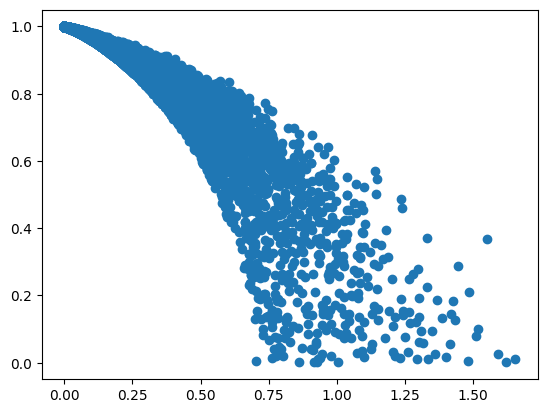

In [ ]:
def calculate_margin_of_probability(probabilities):
    # Get the top two probabilities
    top_probs, _ = torch.topk(probabilities, 2)

    # Calculate the margin
    margin = top_probs[:, 0] - top_probs[:, 1]
    return margin


# Get the top two probabilities
top_probs, _ = torch.topk(probabilities, k=2, dim=1)
# Calculate the margin
margin = top_probs[:, 0] - top_probs[:, 1]

# margs = calculate_margin_of_probability(probabilities)

plt.scatter(ents, margin.detach().numpy())

In [ ]:
train_ad.obs["margin"] = margin.detach().numpy()
train_ad.obs["entropy"] = entropy.detach().numpy()
train_ad.obs["maxprob"] = maxprob
train_ad.obs["pred"] = encoder_celltype.inverse_transform(preds)

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


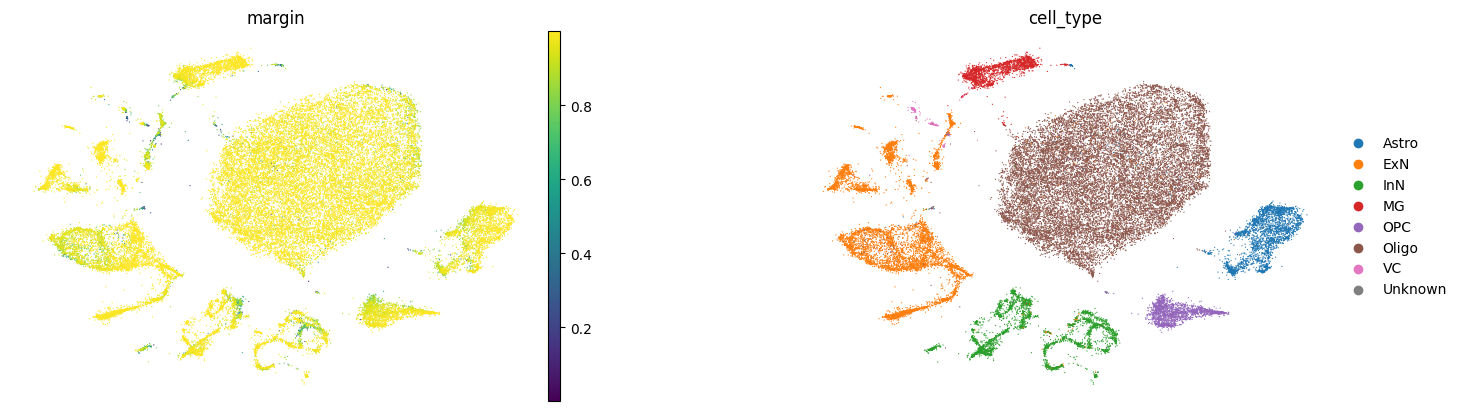

In [ ]:
sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["margin", "cell_type"],
    frameon=False,
    wspace=0.35,
)

/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


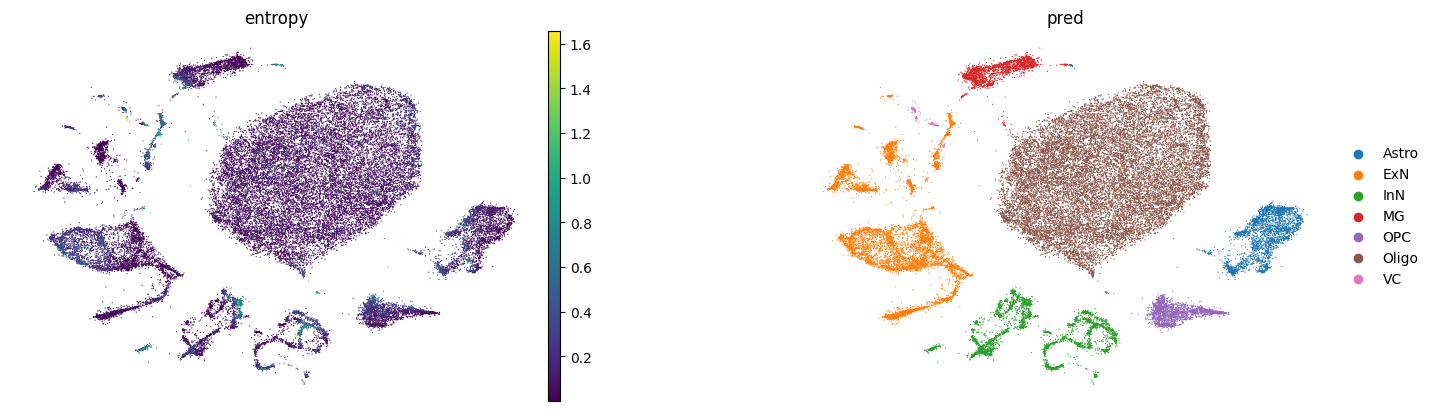

In [ ]:
sc.pl.embedding(
    train_ad,
    basis="X_mde2",
    color=["entropy", "pred"],
    frameon=False,
    wspace=0.35,
)

In [ ]:
train_ad.obs[train_ad.obs["cell_type"] == "Unknown"]

seurat_clusters cell_type         sample  \
cells                                                              
CACATAATCAAACCGT-1_138                1   Unknown  UMARY-933-ARC   

                        doublet_score  nCount_RNA  nFeature_RNA  percent.mt  \
cells                                                                         
CACATAATCAAACCGT-1_138       0.089965       11383          4936    0.131775   

                        percent.rb   batch   S.Score  ...    UMAP_2 clean  \
cells                                                 ...                   
CACATAATCAAACCGT-1_138    1.511025  batch5 -0.070626  ... -9.666387  True   

                         test  train                  tmp  size_factors  \
cells                                                                     
CACATAATCAAACCGT-1_138  False   True  nanOligodendrocytes        4374.0   

                          margin   entropy  maxprob  pred  
cells                                                      
CACATAATCAAACCGT-1_138  0.236207  1.085259  0.54742   ExN  

[1 rows x 32 columns]

In [ ]:
df = test_ad.obs.groupby(["C_scANVI", "ground_truth"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title(
    f"scanvi accuracy: {np.mean(test_ad.obs.C_scANVI == test_ad.obs.ground_truth):.3f}"
)